# CH4 Redes Neuronales

## Importado de Librerías

Importamos todas las librerias y modulos que vamos a usar

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV


import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
import keras.backend as K
# import visualkeras

np.random.seed(1)
tf.random.set_seed(1) 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
semilla = 42
np.random.seed(semilla)
tf.random.set_seed(semilla)

## Lectura CSV y Feature Engineering

Importamos los dataframes necesarios.

In [ ]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

Realizamos feature engineering que consideramos necesarios.

In [ ]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

In [ ]:
# Contamos los valores faltantes
num_missing = df_hotel.isna().sum()
print("El número total de valores faltantes en el DataFrame es:", num_missing.sum())

El número total de valores faltantes en el DataFrame es: 0


In [ ]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

In [ ]:
cambiar_columna_por_probabilidad_is_canceled('country')
cambiar_columna_por_probabilidad_is_canceled('agent')
cambiar_columna_por_probabilidad_is_canceled('company')

In [ ]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

columns = ['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel','deposit_type', 'customer_type', 'assigned_room_type', 'reserved_room_type']

X = pd.get_dummies(X, columns=columns, drop_first=True)

df_hotel_test = pd.get_dummies(df_hotel_test, columns=columns, drop_first=True)

In [ ]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

## Modelo de prueba sin capas intermedias usando SGD

In [ ]:
def get_f1(y_true, y_pred): #Creamos una función para calcular F1 con keras 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=semilla)

In [ ]:
cant_clases=len(np.unique(y_train))

Creamos un modelo simple con una capa de input y otra de output. Usamos el optimizador Stochastic Gradient Descent con un learning rate de 0.001.

In [ ]:
def create_model():
    modelo = keras.Sequential([
        keras.layers.Dense(68, input_shape=(68,), activation='relu', kernel_initializer='uniform'),
        keras.layers.Dense(cant_clases, activation='softmax')
    ])
    
    modelo.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=[get_f1]
    )
    
    return modelo

Le damos una cantidad arbitraria de 10 ciclos

In [ ]:
modelo = KerasClassifier(build_fn=create_model)
historia_modelo=modelo.fit(x_train,y_train,epochs=10,batch_size=32,verbose=True)

Epoch 1/10
1538/1538 [==============================] - 6s 4ms/step - loss: 0.6955 - get_f1: 0.6149
Epoch 2/10
1538/1538 [==============================] - 5s 3ms/step - loss: 0.6320 - get_f1: 0.6393
Epoch 3/10
1538/1538 [==============================] - 4s 3ms/step - loss: 0.6255 - get_f1: 0.6445
Epoch 4/10
1538/1538 [==============================] - 5s 3ms/step - loss: 0.6222 - get_f1: 0.6467
Epoch 5/10
1538/1538 [==============================] - 5s 3ms/step - loss: 0.6195 - get_f1: 0.6533
Epoch 6/10
1538/1538 [==============================] - 6s 4ms/step - loss: 0.6165 - get_f1: 0.6556
Epoch 7/10
1538/1538 [==============================] - 7s 5ms/step - loss: 0.6133 - get_f1: 0.6589
Epoch 8/10
1538/1538 [==============================] - 4s 3ms/step - loss: 0.6106 - get_f1: 0.6643
Epoch 9/10
1538/1538 [==============================] - 5s 3ms/step - loss: 0.6075 - get_f1: 0.6642
Epoch 10/10
1538/1538 [==============================] - 5s 3ms/step - loss: 0.6041 - get_f1: 0.6669

385/385 [==============================] - 1s 2ms/step
12298
12298
              precision    recall  f1-score   support

           0       0.61      0.73      0.66      6180
           1       0.66      0.52      0.58      6118

    accuracy                           0.63     12298
   macro avg       0.63      0.63      0.62     12298
weighted avg       0.63      0.63      0.62     12298



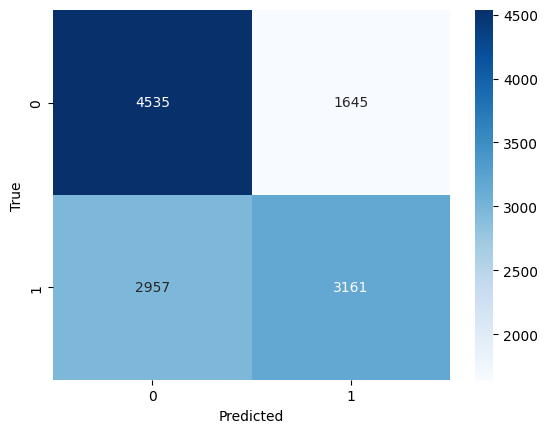

In [ ]:
y_pred = modelo.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred))

Se puede observar que la red sin optimización de hiperparámetros posee una calidad de predicción dudosa. A continuación utilizaremos K-Fold Cross Validation para mejorar este resultado.

## Modelo con K-Fold Cross Validation y Regularización L2


Dividimos nuestros dastos de test y entrenammiento con la semilla correspondiente.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=semilla)

In [ ]:
cant_clases=len(np.unique(y_train))

Creamos una funcion para crear la red. Esta tiene una capa de input, dos capas ocultas y una de output. La cantidad de neuronas de las primeras 3 capas es optimizada utilizando CrossValidation, mientras que la última solo tiene dos neuronas.

In [ ]:
def create_model(optimizer='adam', activation='relu', neurons=64, neurons_2=32, neurons_3=32, regularizer=None):
    modelo = keras.Sequential([
        keras.layers.Dense(68, input_shape=(68,), activation=activation, kernel_initializer='uniform', kernel_regularizer=regularizer),
        keras.layers.Dense(neurons_2, activation=activation, kernel_regularizer=regularizer),
        keras.layers.Dense(neurons_3, activation=activation, kernel_regularizer=regularizer),
        keras.layers.Dense(cant_clases, activation='softmax')
    ])
    
    modelo.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['AUC', 'accuracy', get_f1]
    )
    
    return modelo


### Notas sobre el modelo
<p>1. Optimizar los hiperparámetros epochs y batches aumenta el tiempo de entrenamiento drasticamente (la optimización sin estos hiperparámetros tarda cerca de 1 minuto, de lo contrario puede llegar a tardar 20 minutos).</p>
<p>2. Decidimos no incluir el método de optimización SGD ya que es el más básico y da resultados peores que el resto de modelos.</p>
<p>3. En vez de obtener el best_model creando un nuevo clasificador con los mejores parámetros obtenidos<p>

```
#Ejemplo con nuestro XGBoost del Checkpoint 3
best_model = xgb.XGBClassifier(**best_params)
```
<p>se obtiene haciendo</p> 

```best_model = random_search.best_estimator_```


Optimizaremos los hiperparámetros de nuestra red usando K-Fold Cross Validation.

In [ ]:
param_dist = {
    'optimizer': ['adam', 'nadam'],
    'activation': ['relu', 'sigmoid'],
    'neurons_2': np.linspace(16,192,16),
    'neurons_3': np.linspace(16,192,16),
    'regularizer': [keras.regularizers.l1(0.01), keras.regularizers.l2(0.01), keras.regularizers.l1_l2(l1=0.01, l2=0.01)]
}

modelo_cv = KerasClassifier(build_fn=create_model)
k = 5
kf = KFold(n_splits=k)

random_search = RandomizedSearchCV(
    estimator=modelo_cv,
    param_distributions=param_dist,
    n_iter=15,
    cv=kf,
    verbose=10,
    random_state=semilla,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1538/1538 [==============================] - 10s 5ms/step - loss: 0.9321 - auc: 0.8323 - accuracy: 0.7483 - get_f1: 0.7484


Y entrenamos nuestro modelo con 40 ciclos. Cuando analicemos las métricas más adelante veremos si esta cantidad es suficiente o no.

In [ ]:
cant_epochs = 40

historia_best_model = best_model.fit(x_train, y_train, epochs = cant_epochs, batch_size = 15)

Epoch 1/40
3280/3280 [==============================] - 17s 5ms/step - loss: 0.7671 - auc: 0.8359 - accuracy: 0.7530 - get_f1: 0.7531
Epoch 2/40
3280/3280 [==============================] - 16s 5ms/step - loss: 0.4959 - auc: 0.8803 - accuracy: 0.7928 - get_f1: 0.7928
Epoch 3/40
3280/3280 [==============================] - 16s 5ms/step - loss: 0.4725 - auc: 0.8877 - accuracy: 0.7998 - get_f1: 0.7998
Epoch 4/40
3280/3280 [==============================] - 15s 5ms/step - loss: 0.4621 - auc: 0.8906 - accuracy: 0.8018 - get_f1: 0.8018
Epoch 5/40
3280/3280 [==============================] - 15s 5ms/step - loss: 0.4551 - auc: 0.8923 - accuracy: 0.8036 - get_f1: 0.8036
Epoch 6/40
3280/3280 [==============================] - 16s 5ms/step - loss: 0.4449 - auc: 0.8963 - accuracy: 0.8088 - get_f1: 0.8088
Epoch 7/40
3280/3280 [==============================] - 16s 5ms/step - loss: 0.4412 - auc: 0.8971 - accuracy: 0.8082 - get_f1: 0.8082
Epoch 8/40
3280/3280 [==============================] - 15s 5m

Métricas del conjunto de train

In [ ]:
y_pred = best_model.predict(x_train)

f1 = f1_score(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de train:", f1)
print("Accuracy en el conjunto de train:", accuracy)
print("Precision en el conjunto de train:", precision)

1538/1538 [==============================] - 2s 2ms/step
Mejores hiperparámetros encontrados: {'regularizer': <keras.regularizers.L2 object at 0x7fa26d2707c0>, 'optimizer': 'nadam', 'neurons_3': 98.13333333333333, 'neurons_2': 168.53333333333333, 'activation': 'relu'}
F1_score en el conjunto de train: 0.8259657815282188
Accuracy en el conjunto de train: 0.8172060497641893
Precision en el conjunto de train: 0.7913220841832005


Métricas del conjunto de prueba

In [ ]:
y_pred = best_model.predict(x_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)

385/385 [==============================] - 1s 2ms/step
Mejores hiperparámetros encontrados: {'regularizer': <keras.regularizers.L2 object at 0x7fa26d2707c0>, 'optimizer': 'nadam', 'neurons_3': 98.13333333333333, 'neurons_2': 168.53333333333333, 'activation': 'relu'}
F1_score en el conjunto de prueba: 0.822239502332815
Accuracy en el conjunto de prueba: 0.8141161164416978
Precision en el conjunto de prueba: 0.7841886680510234


Como se puede observar, el mejor método de regularización resulta ser L2 para nuestro caso, y la cantidad de neuronas es decreciente a medida se avanza en las capas ocultas.
 Sumado a eso, vemos que los puntajes F1 en test y train son muy parecidos, por lo que suponemos que L2 hace un buen trabajo en evitar el overfitting y nuestro modelo generalizará bien para datos nuevos.

## Métricas

### Matriz de Confusión

              precision    recall  f1-score   support

           0       0.85      0.76      0.81      6180
           1       0.78      0.86      0.82      6118

    accuracy                           0.81     12298
   macro avg       0.82      0.81      0.81     12298
weighted avg       0.82      0.81      0.81     12298



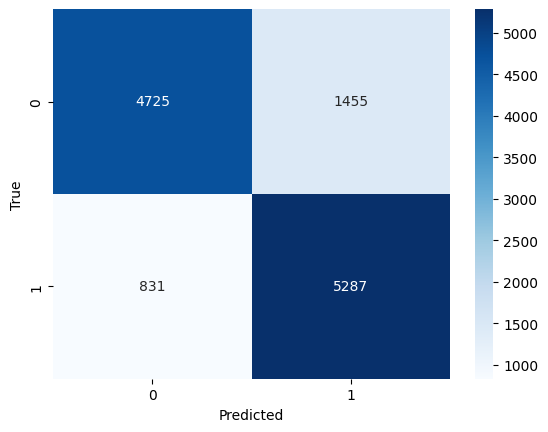

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred))

La matriz de confusión es lo suficientemente balanceada, aunque es un tanto más precisa en los casos en los que no se cancela la reserva.

### Gráficos de las métricas en función de los ciclos (epochs)

In [ ]:
'''epochs = range(cant_epochs)

plt.plot(epochs, historia_best_model.history[f1_score_metric], color='magenta', label='F1 Score')
plt.xlabel("epochs")
plt.ylabel("F1 Score")
plt.legend()'''

'epochs = range(cant_epochs)\n\nplt.plot(epochs, historia_best_model.history[f1_score_metric], color=\'magenta\', label=\'F1 Score\')\nplt.xlabel("epochs")\nplt.ylabel("F1 Score")\nplt.legend()'

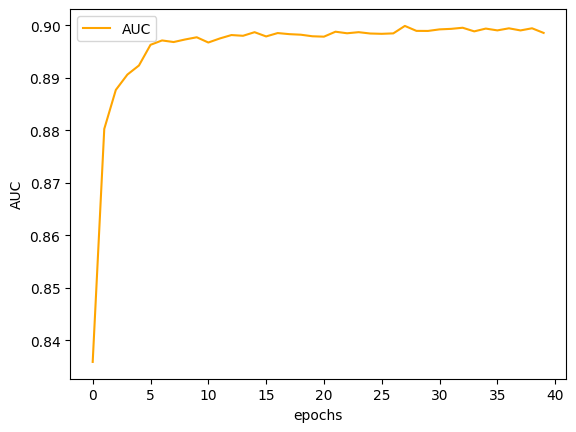

In [ ]:
epochs = range(cant_epochs)

plt.plot(epochs, historia_best_model.history['auc'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

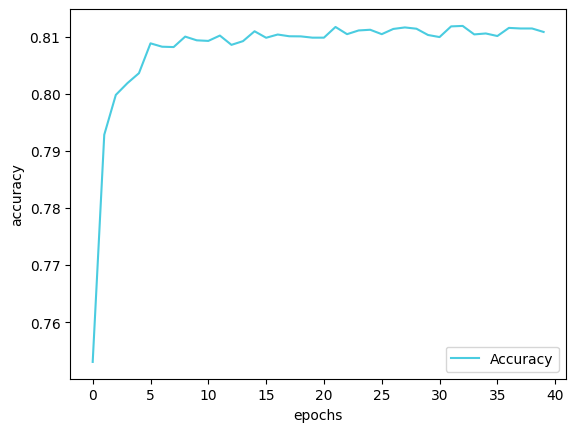

In [ ]:
epochs = range(cant_epochs)

plt.plot(epochs, historia_best_model.history['accuracy'], color='#4acce0', label='Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

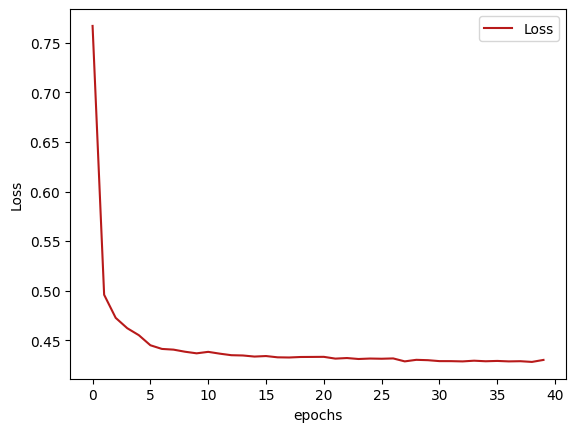

In [ ]:
epochs = range(cant_epochs)

plt.plot(epochs, historia_best_model.history['loss'], color='#b81a1a', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

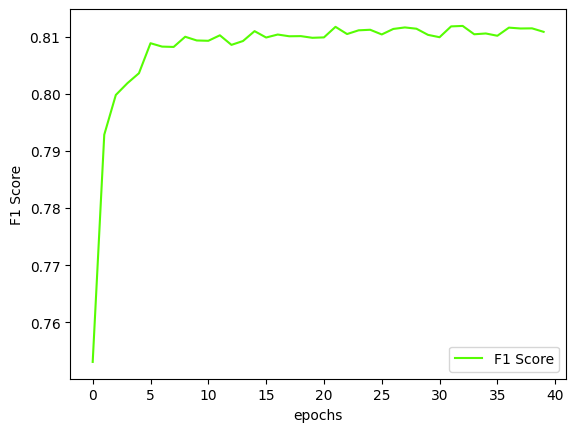

In [ ]:
epochs = range(cant_epochs)

plt.plot(epochs, historia_best_model.history['get_f1'], color='#56fc03', label='F1 Score')
plt.xlabel("epochs")
plt.ylabel("F1 Score")
plt.legend()

En los gráficos podemos ver como a partir de los 10 ciclos, la tasa en la que se reduce el error y aumentan las métricas AUC y de accuracy decrece extremadamente, por lo que suponemos que utilizar 40 ciclos fue una buena idea para lograr un buen balance entre la calidad de nuestra predicción y el tiempo de entrenamiento.

## Exportado de Predicciones

In [ ]:
import joblib
joblib.dump(best_model, 'modelo_red_neuronal.pkl')
loaded_model = joblib.load('modelo_red_neuronal.pkl')
predicciones = loaded_model.predict(df_hotel_test)

830/830 [==============================] - 1s 2ms/step


In [ ]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': predicciones})
df_sub.to_csv('prediccion_redn_1.csv', index=False)